#### **PyTorch**

In [1]:
import torch
import torch.nn.functional as F
print(f"PyTorch Version: {torch.__version__}")

import torch
print(f"Cude is available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.3.1+cu121
Cude is available: True
Device name: NVIDIA A10


#### **Import Other Libraries**

In [2]:
# Standard library imports
import os
import time 

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import DecoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import anthropic

import jax 
import jax.numpy as jnp 
import optax 
from rfp import MLP, Model, ModelParams
from rfp.utils import batch_matrix_with_padding
from rfp.losses import binary_cross_entropy, Supervised_Loss, mse
from rfp.train import Trainer
import time 


import concurrent.futures
import time
from tqdm import tqdm
import re 

#### **Parameters**

In [3]:
seed = 3
noise = False 
version = 4 
sample_size = 800
test_size = 0.25
nodes = 32
lr = 1e-3
epochs = 10_000

#### **Seed**

In [4]:
np.random.seed(seed)

#### **Set Up Paths**

In [5]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_24pt/Newsreader_24pt-SemiBold.ttf


#### **First Stage Function**

In [7]:
def fstage(var0, var1, var2, var3, var4):
    return 0.35*(var3 >= 3) + 0.5*var4

#### **Read in Data**

In [8]:
def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n'
string1 = "Note: Free legal representaiton is available in the tenant's zip code.\n\n"
string0 = "Note:  Free legal representaiton is not available in the tenant's zip code.\n\n"

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(row['Var0'],
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                            string1 + 'Description:' + df['Description'].replace("\n", ""),
                            string0 + 'Description:' + df['Description'].replace("\n", ""))

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + np.random.normal(size=sample_size)

In [9]:
df.head()

,Var0,Var1,Var2,Var3,Var4,Description,FStage_Value,Instrument,FullDescription,Treatment,Outcome
0,1,0,1075,0,0,The tenant is a young professional in their la...,0.00,0,Note: Free legal representaiton is not availa...,0,-0.101069
1,8,0,776,4,1,The tenant is a middle-aged individual in thei...,0.85,1,Note: Free legal representaiton is available i...,1,3.199759
2,0,2,1361,6,1,The tenant is a young individual in their mid-...,0.85,0,Note: Free legal representaiton is not availa...,0,-1.737135
3,4,2,1108,6,1,The tenant is a 38-year-old individual with se...,0.85,1,Note: Free legal representaiton is available i...,1,2.446640
4,2,1,1472,0,0,The tenant is a young professional in their ea...,0.00,1,Note: Free legal representaiton is available i...,0,-0.552846


#### **Joint Distribution**

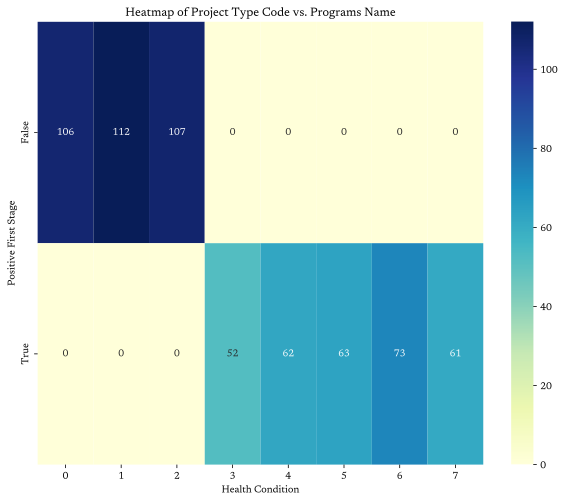

In [10]:
df['PositiveFstage'] = df['FStage_Value'].apply(lambda x : x>0.)
df_temp = df[df['Var4'] ==0]
crosstab = pd.crosstab(df_temp['PositiveFstage'], df_temp['Var3'])

# Plot the crosstab using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')

# Add titles and labels
plt.title('Heatmap of Project Type Code vs. Programs Name')
plt.xlabel('Health Condition')
plt.ylabel('Positive First Stage')

# Show the plot
plt.show()

#### **Plot**

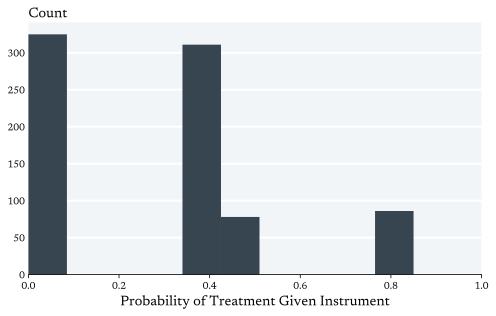

In [11]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

##### **Set Up Device**

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [13]:
df['Health'] = df['Var3'].apply(lambda x: 1.0*(x>=3))

#### **Cross Tabs**

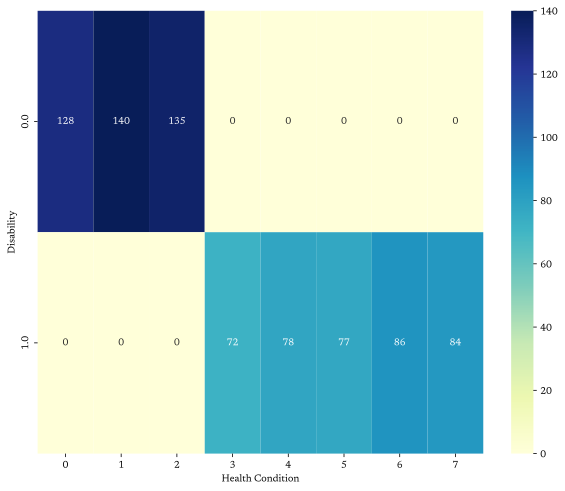

In [14]:
crosstab = pd.crosstab(df['Health'], df['Var3'])

# Plot the crosstab using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')

# Add titles and labels
plt.xlabel('Health Condition')
plt.ylabel('Disability')

# Show the plot
plt.savefig(f'heatmap_{seed}.png')
plt.show()

In [15]:
df_temp = df[(df['Health'] == 1) & (df['Var3'] < 3)]
print(df_temp.shape)

(0, 13)


In [16]:
df = pd.get_dummies(df, columns=['Var0', 'Var1', 'Var4'], drop_first=True)

In [17]:
# Select columns that start with 'Var'
var_columns = [col for col in df.columns if col.startswith('Var')] + ['Health']
var_columns = [var for var in var_columns if var != 'Var3']

# Create a numpy matrix from the selected columns
X = df[var_columns].to_numpy().astype(float)

# Feature Matrix
X_normalized = jnp.hstack((jax.nn.standardize(X[:,0]).reshape(-1,1),  X[:,1:]))
print(f"Feature shape: \t\t{X.shape}")
print(f"Feature shape: \t\t{X_normalized.shape}")

D = jnp.array(df['Treatment'].values.reshape(-1,1)).astype(float)
Z = jnp.array(df['Instrument'].values.reshape(-1,1)).astype(float)
inputs = jnp.hstack((X_normalized, Z))

Feature shape: 		(800, 16)
Feature shape: 		(800, 16)


2024-06-19 23:46:35.498123: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a reco

In [18]:
features = inputs.shape[1] ; print(f"Number of Features: {features}")
mlp = MLP([nodes, nodes], jax.nn.relu)
final_activation_fn = jax.nn.sigmoid 
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(binary_cross_entropy, model.embellished_fwd_pass)
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)

Number of Features: 17


In [19]:
# Initialize random key
key = jax.random.PRNGKey(seed)

# Create keys
key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)

# Initialize parameters
params = ModelParams.init_fn(subkey1, mlp, features)

# Split Train and Validation Data
# Shuffle the indices
idx = jax.random.permutation(subkey2, inputs.shape[0])

# Determine the indices for training and validation sets
train_size = int((1 - test_size) * inputs.shape[0])
train_indices = idx[:train_size]
val_indices = idx[train_size:]

# Create boolean masks for training and validation sets
is_in_train = jnp.isin(jnp.arange(inputs.shape[0]), train_indices)
is_in_val = jnp.isin(jnp.arange(inputs.shape[0]), val_indices)

# Train the model
params, opt_params, train_loss_history, val_loss_history = yuri.train_with_val(params, inputs, D, jnp.ones_like(D), is_in_train, is_in_val)

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

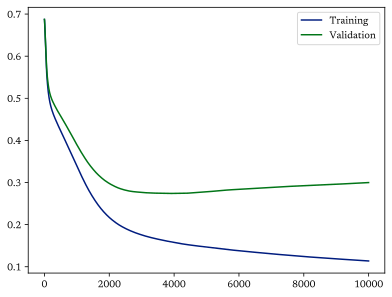

In [20]:
plt.plot(train_loss_history, label='Training')
plt.plot(val_loss_history, label='Validation')
plt.legend()
plt.show()

In [21]:
Dhat = np.array(model.fwd_pass(opt_params, inputs))
Dhat1 = np.array(model.fwd_pass(opt_params, jnp.hstack((X_normalized, jnp.ones_like(Z)))))
Dhat0 = np.array(model.fwd_pass(opt_params, jnp.hstack((X_normalized, jnp.zeros_like(Z)))))
residuals = Dhat - (0.5*Dhat1 + 0.5*Dhat0)
est = jnp.linalg.lstsq(jnp.hstack((residuals.reshape(-1,1), jnp.ones_like(residuals.reshape(-1,1)))), jnp.array(df['Outcome'].values.reshape(-1,1)))[0][0]
df_result = pd.DataFrame({'Estimate': est})
print(est)

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

[3.8020942]


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


(0.0, 1.0)

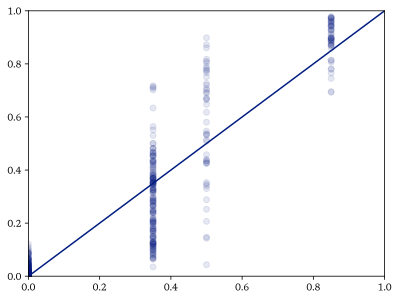

In [22]:
v = (df['FStage_Value']*df['Instrument']).values
plt.scatter(v, Dhat.reshape(-1,), alpha=0.1)
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)

In [23]:
# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/oracle_{version}_{sample_size}_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df_result[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df_result[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)

: 